


**Abstract**:


# Introduction

This document describes the development and analysis of the results of a Rogowski coil design and signal conditioning circuit

# Methodology 

The design of a rogowski coil has been separated in two parts: FEM (*Finite Element method*), where the mechanical part is developed, and signal conditioning, where the circuit of conditioning is develped. Below, all these steps are described.

## FEM Modeling

The Rogowski Coil FEM simulation need a mechanical model for the simulation, where the physical characteristics are described for tools solve this physics. Rogowski's coil model [1] is in the sequence picture, where it was modeled on the SOLIDWORKS® tool in an educational version.

<!--- ![Boundaries](images/Dimensions.png) -->

<figure>
  <img src="images/Dimensions.png"  width="500"/>
  <figcaption>FEMM Boundaries.</figcaption>
</figure>

The dimensions and number of turns has been developed to satisfact the minimum voltage for the signal conditioner, that are 10 mV for 100 A of current in 60 Hz.

To simulate the magnetic problem, we use the free software FEEM (Finite Element Method Magnetics), that provide a good API (Application Programming Interface) in Python for automate simulations, and solve planar magnetics problems. The figure in the sequence, describe the model imported from SOLIDWORKS® and after added definitions in boundaries. This model in FEMM have many techniques for simulate, but how the mode of simulation is planar, is necessary to indicate que number os turn to define a loop of current. It can be seen in the last image, where have the cable the copper in the center of Rogowski coil, and the return is near boundaries, to close the magnetic circuit whit the current Im (current of motor).

<!--- ![Boundaries](images/FEEM_Boundary.PNG) -->
<figure>
  <img src="images/FEEM_Boundary.PNG"  width="500"/>
  <figcaption>FEMM Boundaries.</figcaption>
</figure>

The figure in sequence, describe the Rogowski coil, in a zoom in the center of the last image. How can we see, have a copper cable (10 AWG) in center and 20.000 turns of copper cable (24 AWG) too. In the center of toroid, have the return loop of copper, for minimization of external interferences.

<!--- ![FEMM Rogowski Coil](images/FEMMRogowskiCoil.PNG) -->
<figure>
  <img src="images/FEMMRogowskiCoil.PNG"  width="500"/>
  <figcaption>FEMM Rogowski Coil.</figcaption>
</figure>


After insert all mechanical model, physical characteristics and solutions parameters, the mesh can be generated. The picture in the sequence represents this mesh, with 31421 nodes without errors.

<!---![Boundaries](images/FEMMMesh.PNG) -->

<figure>
  <img src="images/FEMMMesh.PNG"  width="550"/>
  <figcaption>Mesh.</figcaption>
</figure>

The following code in Python use the FEMM API for simulate the Rogowski coil in differents frequencies, to get the frequency response in a especifica bandwidth, from 10 mHz to more than 10 kHz

In [1]:
# imports all needed modules
import femm
import time
import os
import numpy as np
import cmath as cm
import random
import pandas as pd 
from ipywidgets import IntProgress
from IPython.display import display
from scipy import fftpack
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
%matplotlib inline

In [2]:
# cell for simulate a Rogowski coil in FEMM tool
femm.openfemm()
femm.opendocument("simulations/femm/rogowski_simulation.fem");
femm.mi_saveas("simulations/femm/temp.fem")
femm.mi_seteditmode("group")
vr=[];
f=[];

units = "millimeters"
stype = 'planar'
precision = 10**-8
depth = 1
minangle = 30
acsolver = 0 # 0 to successive approximation or 1 to Newton  

# number of interaction
init = 0
final = 4 

progress = IntProgress(min=init, max=final,
                       description='Simulation:') # instantiate the bar
display(progress) # display the bar

init_time = time.time()

for n in range(init,final): 
    if n == 0:
        n=0.00001
        
    freq = 1000*n
    f.append(freq)
    femm.mi_probdef(freq,units,stype,precision,depth,minangle,(acsolver))
    femm.mi_analyze()
    femm.mi_loadsolution() 
    femm.mo_groupselectblock(1)  # get the Ir voltage drop
    v=femm.mo_getcircuitproperties("Ir")
    vr.append(v[1])
    progress.value = n+1
femm.closefemm()

print('Time: ' + str(time.time() - init_time) + 's')

IntProgress(value=0, description='Simulation:', max=4)

Time: 21.899375915527344s


How can we see, in the script, the FEMM API have a function to get the voltage drop in a circuit, where we get the voltage in circuit Ir (Rogowski circuit) for build the frequency response.

The next step is to design an electronic circuit to integrate the Rogowski signal, amplify and add a half offset of the voltage source.

## Signal Conditionig

In this section, the design o a signal conditioner is described, where are divided in 3 parts: integrator, PGA (Programable gain amplifier) and DC Offset. And in the final, Monte carlo Method to calculate the noise and the uncertainty of measurement.

### Integrator

This stage is one of the most important of conditioning, because the integration are in low frequency, working like a low-pass filter, inhibiting the PGA gain in a wide range of noises, besides integrating the Rogowski coil voltage according to the following equation [1]:

$$ i(t) = \frac{1}{M}\int_{0}^{T}{u_r(t)dt}$$

Where, i(t) is a real value of current representation in voltage, M is the mutual inductance between the cable inductance and the Rogowski coil, and ur is the drop voltage between the two terminals of the coil.

To meet specifications, the cut frequency must to be less than 6 Hz, being a decade down of 60 Hz, the down limit of specifications. For this reason, we can calculate the passive low pass filter this way [2]:

<!---![Passive Low pass Filter.](images/rc.PNG) -->

<figure>
  <img src="images/rc.PNG"  width="300"/>
  <figcaption>Passive Low pass Filter.</figcaption>
</figure>

Where the transfer function is:

$$\frac{V_o}{V_i} = \frac{1}{sRC+1}$$

Where the cutoff frequency is:

$$f_c = \frac{1}{2\pi RC}$$

After integration, we need to amplify the signal to a level to enable the sampling in an ADC (Analog-to-digital converter), which will be described below.

### Instrumentation PGA 

This is an important step of development, because the signal of Rogowski coil after integration, is less than 10 mV, and the characteristics of this stage can insert disturbs, noise and a big frequency response error. Therefore, the choice of a good PGA or another topology for an instrumentation amplifier is necessary to attend the specifications and minimize this problems. AD8253 PGA instrumentation is a good choice for this project, has the following characteristics [3]:


|    Feature     |   Values  |
|----------------|-----------|
|   Slew rate    |  20 V/μs  |
|   Bandwidth    |  10 MHz   |
|      Noise     |  45 nV/√H |
| Setteling Time |  0.78 μs  |
|      Gain      |  1, 10, 100 or 1000  |

Where low noise and high rate of change are the most important features for this circuit. The complete conditioning circuit is in sequence, represented in LTspice® tool:

![Simulated Circuit in LTspice](images/circuit_final.PNG)

The DC offset of half of the power supply in the last figure is given by the OP1177 operational amplifier according to manufacturer design reference AD8253 [3]. 

It is common and prudent to add a circuit to prevent the effect of aliasing on a sampled signal, but in this project, the anti-aliasing filter is a problem, where the sampling frequency is 10 KHz and the gain is elavated (60dB), the cutoff frequency it has to be from 500 Hz - 1 decade before the half of sampling frequency (Nyquist Theorem)-  for a low gain in 5 Khz. As the interest frequency range is from 6 Hz to 5kHz, the anti-aliasing filter will eventually modify much of the signal of interest not being able to use it in this project.

# Results

## FEM Analisys


<!-- ![FEMM boundaries results](images/FEEM_Result_Boundaries.PNG) -->
<figure>
  <img src="images/FEEM_Result_Boundaries.PNG"  width="500"/>
  <figcaption>FEMM boundaries results.</figcaption>
</figure>

<!-- ![FEMM Rogowski coil results](images/FEEM_Result_Coil.PNG) -->
<figure>
  <img src="images/FEEM_Result_Coil.PNG"  width="500"/>
  <figcaption>FEMM Rogowski coil results.</figcaption>
</figure>

Text(0.5, 0, 'Frequency [Hz]')

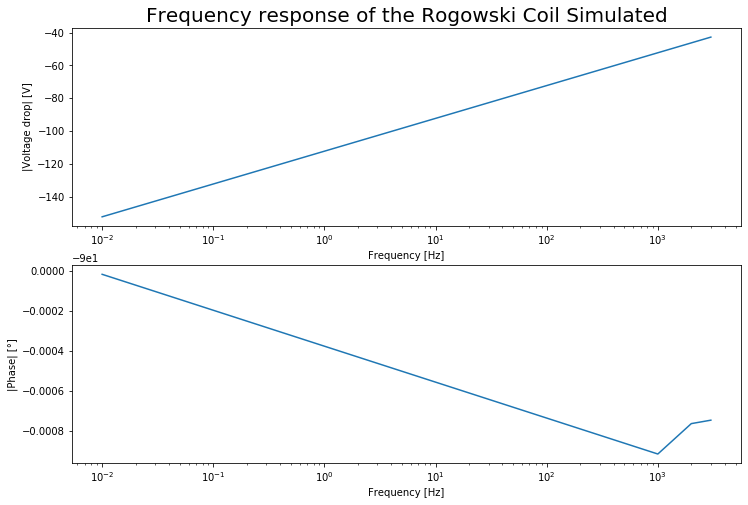

In [3]:
# Plot of Rogowski coil frequency response 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
ax[0].semilogx(f,20*np.log10(np.abs(vr)/100))
ax[0].set_ylabel('|Voltage drop| [V]')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_title('Frequency response of the Rogowski Coil Simulated', fontsize=20)

ax[1].semilogx(f,np.angle(vr)*180/np.pi)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

In [4]:
# Rogowski Coil Gain
gain = np.abs(vr[-1])/(100*f[-1])
display(gain)

2.4416613655426696e-06

In [5]:
# Read a file with real values of current, sampled in a 
# didatic plant for vibration analysis
file_data = pd.read_csv('simulations/MotorDesbalanceado.csv')
    
# get set of data from .csv file
data = 330*file_data['Amperimeter']
len_data = len(data)
   
init = 0.5
final = 0.55

# sample Rate in Hz
f_s = 10000

data_plot = data[int(init*len_data+1):int(final*len_data)]
fft_data = fftpack.fft(data_plot)
amplitude = np.abs(fft_data)
phase = np.angle(fft_data)
freqs = fftpack.fftfreq(len(data_plot)) * f_s

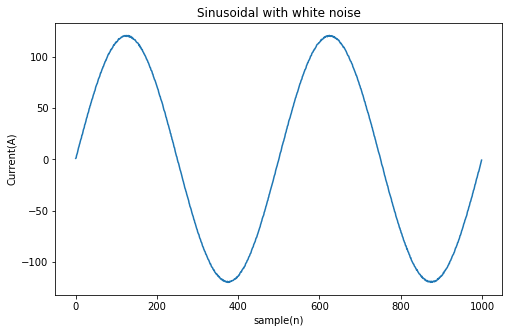

In [6]:
# Another possibility, is create a new signal with white noise,
# creating a more controllable scenario to simulate
Fs = 10000
f = 20
x = np.arange(len_data)
noise = 3e-8*np.asarray(random.sample(range(0,len_data),len_data))
 
y_noise = 120*(np.sin(2 * np.pi * f * x / Fs)+noise)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(y_noise[0:1000])
ax.set_ylabel('Current(A)')
ax.set_xlabel('sample(n)')
ax.set_title('Sinusoidal with white noise')

data_plot_sml = y_noise[int(init*len_data+1):int(final*len_data)]
fft_data_sml = fftpack.fft(data_plot_sml)
amplitude_sml = np.abs(fft_data_sml)
phase_sml = np.angle(fft_data_sml)
freqs_sml = fftpack.fftfreq(len(data_plot_sml)) * f_s

In [7]:
# Calculates the Rogowski voltage from the product between Rogowski coil frequency
# response and the currente imported from another sensor
AmplReal = []
PhsReal = []
polarReal = []

AmplSml = []
PhsSml = []
polarSml = []

for n in range(0, len(freqs)):
    AmplReal.append(amplitude[n]*gain*freqs[n])
    PhsReal.append(phase[n]*(180/np.pi) + 90)
    polarReal.append(cm.rect(AmplReal[n], PhsReal[n]))
    
    AmplSml.append(amplitude_sml[n]*gain*freqs_sml[n])
    PhsSml.append(phase_sml[n]*(180/np.pi) + 90)
    polarSml.append(cm.rect(AmplSml[n], PhsSml[n]))

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


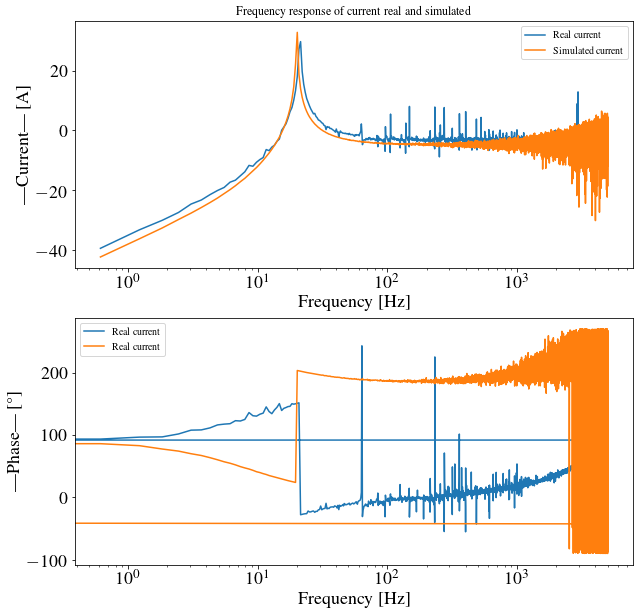

In [9]:
# Rogowski voltage Frequency response of a real current
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(freqs,20*np.log10(AmplReal), label='Real current')
ax[0].semilogx(freqs_sml,20*np.log10(AmplSml), label='Simulated current')
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_title('Frequency response of current real and simulated')
ax[0].legend()

ax[1].semilogx(freqs,PhsReal, label='Real current')
ax[1].semilogx(freqs_sml,PhsSml, label='Real current')
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].legend()

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


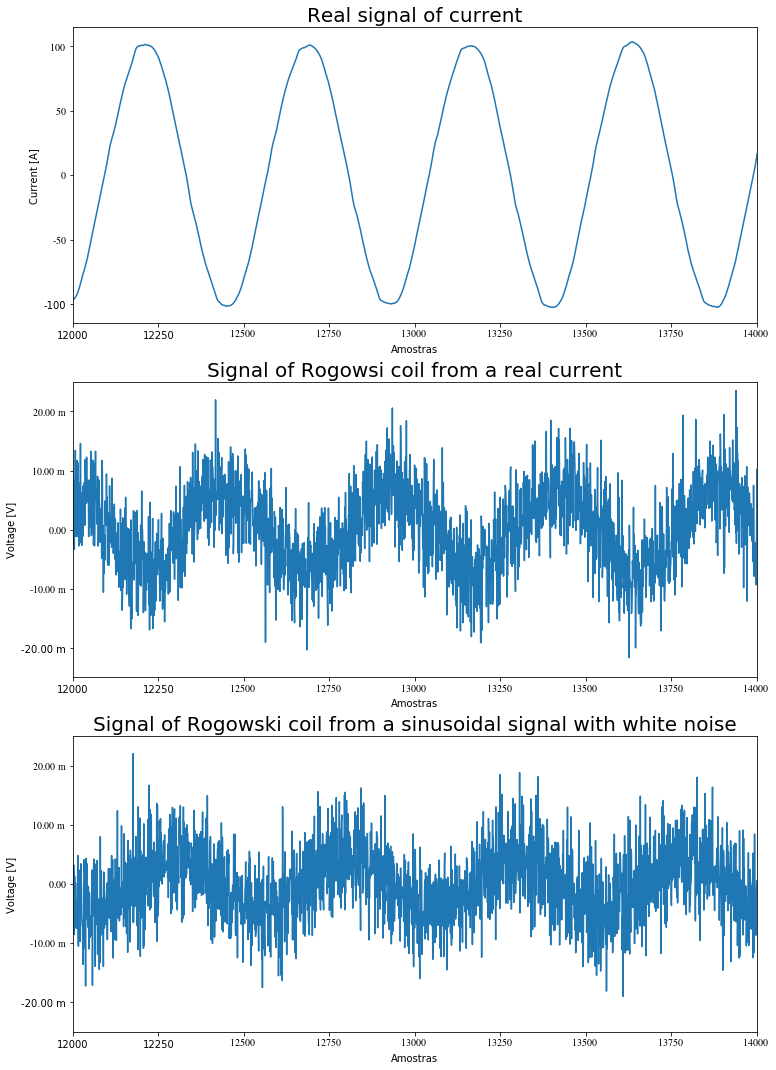

In [8]:
# Inverse fft of the Rogowski voltage of a real current
signal_rogowski_real = fftpack.ifft(polarReal)
signal_rogowski_sml = fftpack.ifft(polarSml)

# plot and compare ifft with a real current
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,15))
formatter1 = EngFormatter(places=2)

ax[0].plot(data)
ax[0].set_ylabel('Current [A]')
ax[0].set_xlabel('Amostras')
ax[0].set_xlim(12000, 14000)
ax[0].set_title('Real signal of current', fontsize=20)

ax[1].plot(signal_rogowski_real)
ax[1].set_ylabel('Voltage [V]')
ax[1].set_xlabel('Amostras')
ax[1].set_xlim(12000, 14000)
ax[1].set_ylim(-0.025, 0.025)
ax[1].yaxis.set_major_formatter(formatter1)
ax[1].set_title('Signal of Rogowsi coil from a real current' \
                 , fontsize=20)

ax[2].plot(signal_rogowski_sml)
ax[2].set_ylabel('Voltage [V]')
ax[2].set_xlabel('Amostras')
ax[2].set_xlim(12000, 14000)
ax[2].set_ylim(-0.025, 0.025)
ax[2].yaxis.set_major_formatter(formatter1)
ax[2].set_title('Signal of Rogowski coil from a sinusoidal \
signal with white noise', fontsize=20)

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)
plt.subplots_adjust(left=0.04, right=0.99, top=0.97, bottom=0.04)

In [10]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wav_gain = 1000000000 
wave = wav_gain*(np.real(signal_rogowski_real))
iwave = wave.astype(int)

wavfile.write('simulations/ltspice/vRogowski.wav', sampleRate, iwave)

In [11]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wave = wav_gain*(np.real(signal_rogowski_sml))
iwave = wave.astype(int)

wavfile.write('simulations/ltspice/vRogowskiSml.wav', sampleRate, iwave)

In [12]:
data_real = []
data_sml = []
time = []
signal_real = []
signal_sml = []

with open ("simulations/ltspice/vRogowski.wav.txt", "r") as myfile:
    for line in  myfile:
        data_real.append(line)  
        
with open ("simulations/ltspice/vRogowskiSml.wav.txt", "r") as myfile:
    for line in  myfile:
        data_sml.append(line)   

data_real.pop(0)
data_sml.pop(0)

for x in range(len(data_real)):
    aux_real = data_real[x].split("	")
    aux_sml = data_sml[x].split("	")
    time.append(float(aux_real[0]))
    signal_real.append(float(aux_real[1].strip('\n')))
    signal_sml.append(float(aux_sml[1].strip('\n')))

Text(0.5, 1.0, 'Output of signal conditioner')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


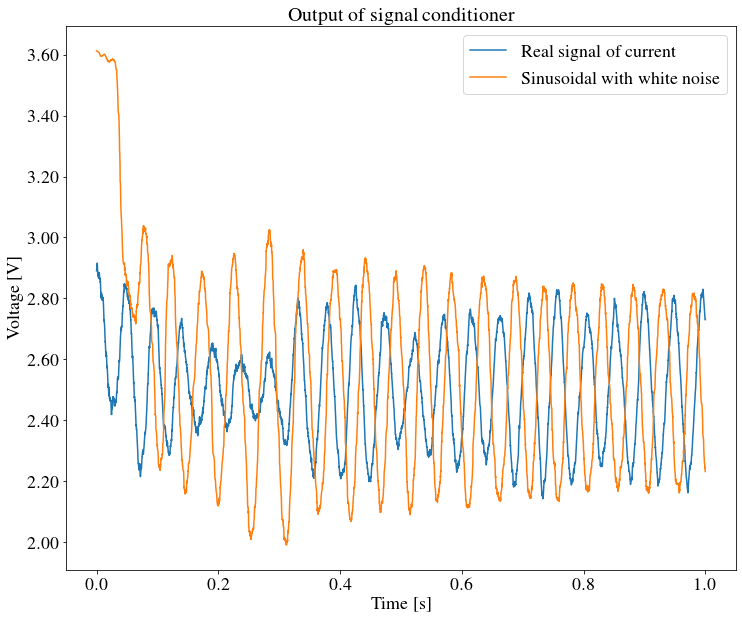

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
formatter1 = EngFormatter(places=2)

ax.plot(time, signal_real, label='Real signal of current')
ax.plot(time, signal_sml, label='Sinusoidal with white noise')
ax.set_ylabel('Voltage [V]')
ax.set_xlabel('Time [s]')
ax.yaxis.set_major_formatter(formatter1)
ax.legend(fontsize=18)
ax.set_title('Output of signal conditioner', fontsize=20)

## Monte Carlo Simulations

In [19]:
data = []
frequency = []
aux = []
ampl = []
ph = []
cnt_step = -1

with open ("simulations/ltspice/\
MC_AC_AnalogRogowskiSignalProc.txt", "r") as myfile:
    for line in  myfile:
        data.append(line)            

data.pop(0)

for y in data:
    aux = y.split(" ")
    if(aux[0] == 'Step'):
        cnt_step = cnt_step + 1
        frequency.append([])
        ampl.append([])
        ph.append([])
        
    else:    
        aux = y.split("	")
        frequency[cnt_step].append(float(aux[0]))
        aux = aux[1].split(",")
        r=float(aux[0])
        im=float(aux[1].strip('\n'))
        polar = cm.polar(complex(r, im))
        ampl[cnt_step].append(polar[0]) 
        ph[cnt_step].append(polar[1]*180/np.pi) 

Text(0.5, 0, 'Frequency [Hz]')

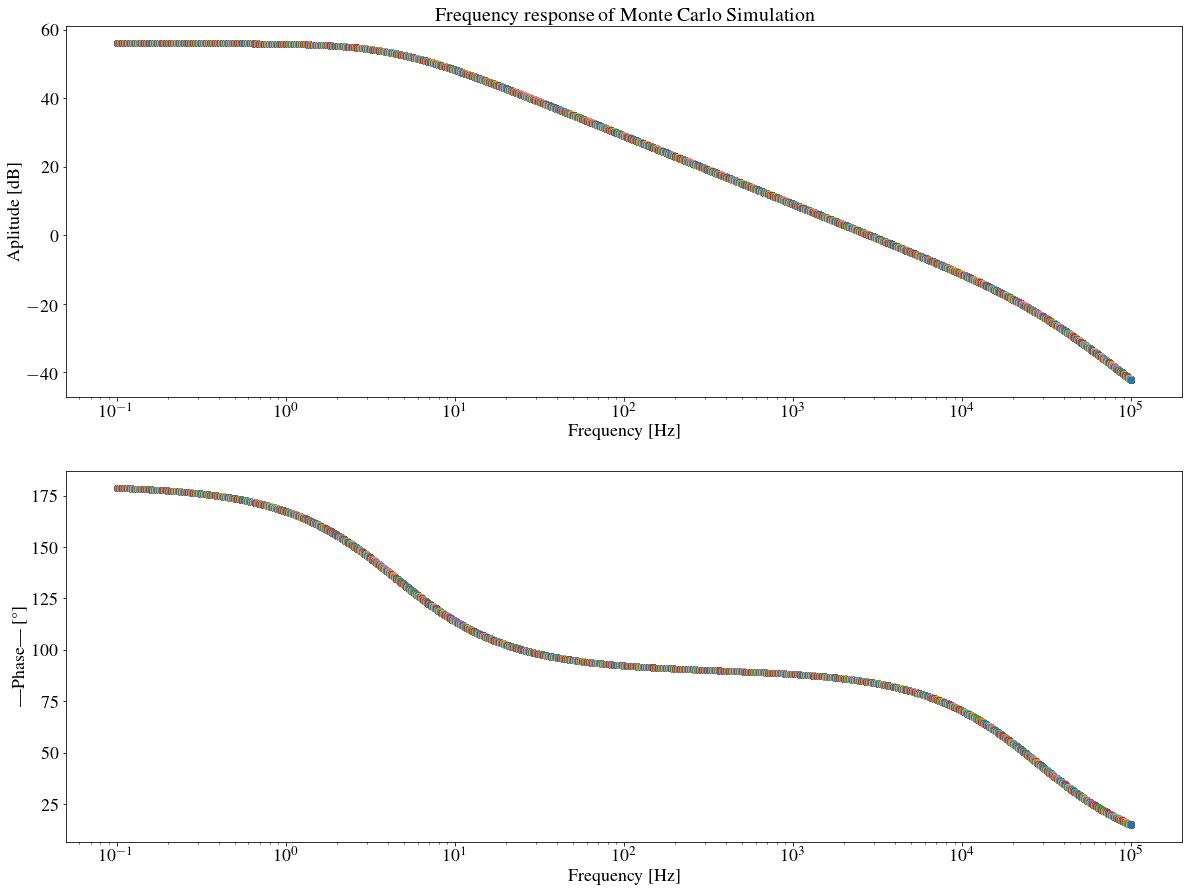

In [20]:
# Plot of Rogowski coil frequency response in Monte Carlo Simulation
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
ax[0].semilogx(frequency, 20*np.log10(np.abs(ampl)), 'o-')
ax[0].set_ylabel('Aplitude [dB]')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_title(' Monte Carlo Frequency response Simulation', fontsize=20)

ax[1].semilogx(frequency,ph, 'o-')
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

## Error in frequency response

### Calculation of the frequency error of the signal conditioning circuit

In [21]:
ampl_err = []
ph_err = []

# Teorical Model from SAPWin Simulator
def teorico(w):
    num = + ( +200000 )+ ( +20000j )*w
    den = + ( +312000 )+ ( +42400j )*w - ( +1120 )*w**2
    rect =  1000*num/den
    polar = cm.polar(complex(rect.real, rect.imag))
    return polar

# For loop for calulate the error of Monte Carlo Results
for y in range(0,len(ampl)):
    ampl_err.append([])
    ph_err.append([])
    for x in range(0,len(ampl[0])):
        tvalue = teorico(2*frequency[y][x]*np.pi)
        ampl_err[y].append(((tvalue[0] - ampl[y][x])/tvalue[0])*100)
        ph_err[y].append(((tvalue[1]*180/np.pi - ph[y][x])/(tvalue[1]\
                           *180/np.pi))*100)

Text(0.5, 1.0, 'Signal conditioner frequency error')

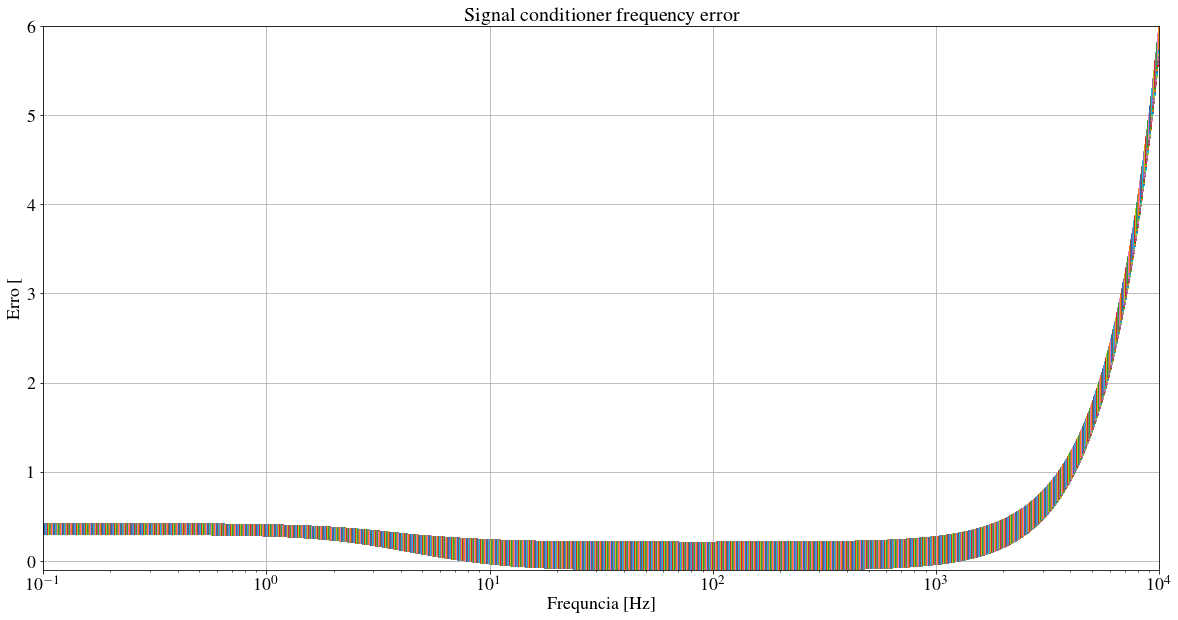

In [22]:
# Plot of Error in frequency of Monte Carlo results of conditioning 
# circuit simulations 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.semilogx(frequency, ampl_err)
ax.set_ylabel('Erro [%]')
ax.set_xlim(0.1,10000)
ax.set_ylim(-0.1,6)
ax.grid(True)
ax.set_xlabel('Frequncia [Hz]')
ax.set_title('Signal conditioner frequency error', fontsize=20)

## Noise 


In [23]:
data = []
frequency = []
aux = []
ampl = []
ph = []
cnt_step = -1

with open ("simulations/ltspice/\
MC_Noise_AnalogRogowskiSignalProc_curve.txt", "r") as myfile:
    for line in  myfile:
        data.append(line)            

data.pop(0)

for y in data:
    aux = y.split(" ")
    if(aux[0] == 'Step'):
        cnt_step = cnt_step + 1
        frequency.append([])
        ampl.append([])
        ph.append([])
        
    else:
        aux = y.split("	")
        frequency[cnt_step].append(float(aux[0]))
        ampl[cnt_step].append(float(aux[1].strip('\n'))) 

Text(0.5, 1.0, 'Noise simulation with Monte Carlo Method')

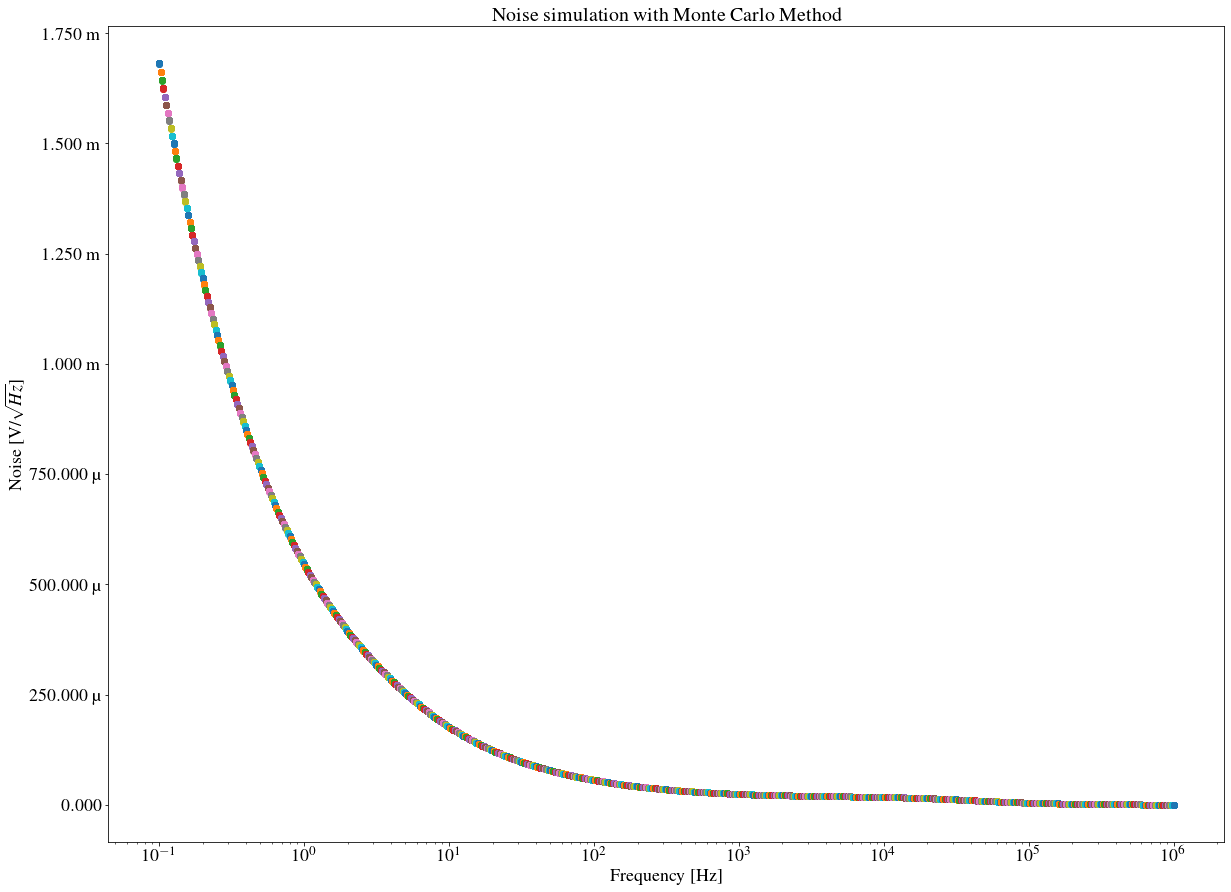

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
formatter1 = EngFormatter(places=3)

ax.semilogx(frequency, ampl, 'o-')
ax.set_ylabel('Noise [V/$\sqrt{Hz}$]')
ax.set_xlabel('Frequency [Hz]')
ax.yaxis.set_major_formatter(formatter1)
ax.set_title('Noise simulation with Monte Carlo Method', fontsize=20)

## Measurement Uncertainty


In [25]:
# Get 
data = []
integral = []

with open ("simulations/ltspice/\
MC_Noise_AnalogRogowskiSignalProc.log", "r") as myfile:
    for line in  myfile:
        data.append(line)            

info = False

for x in data:
    aux = x.split(" ")
    
    if(info == True):
        if(aux[2] == ''):
            aux_2 = x.split('	')
            integral.append(2*float(aux_2[1]))
    if(aux[0] == 'Measurement:'):
        info = True
        
    if(len(integral) == 100):
        break

steps = range(1,101)
max_uncertainty = np.amax(integral)
min_uncertainty =  np.amin(integral)
mean_uncertainty =  np.mean(integral)

| Temperature  | Minimun     |   Typic     |  Maximum   |
|--------------|-------------|-------------|------------|
|     -20°C    |  7.0893mV   |  7.08934mV  |  7.08938mV |
|      20°C    |  7.5630mV   |  7.5631mV   |  7.56316mV |
|      80°C    |  8.4708mV   |  8.4754mV   |  8.4756mV  |

Text(0.5, 1.0, 'Measurement uncertainty per Monte Carlo steps')

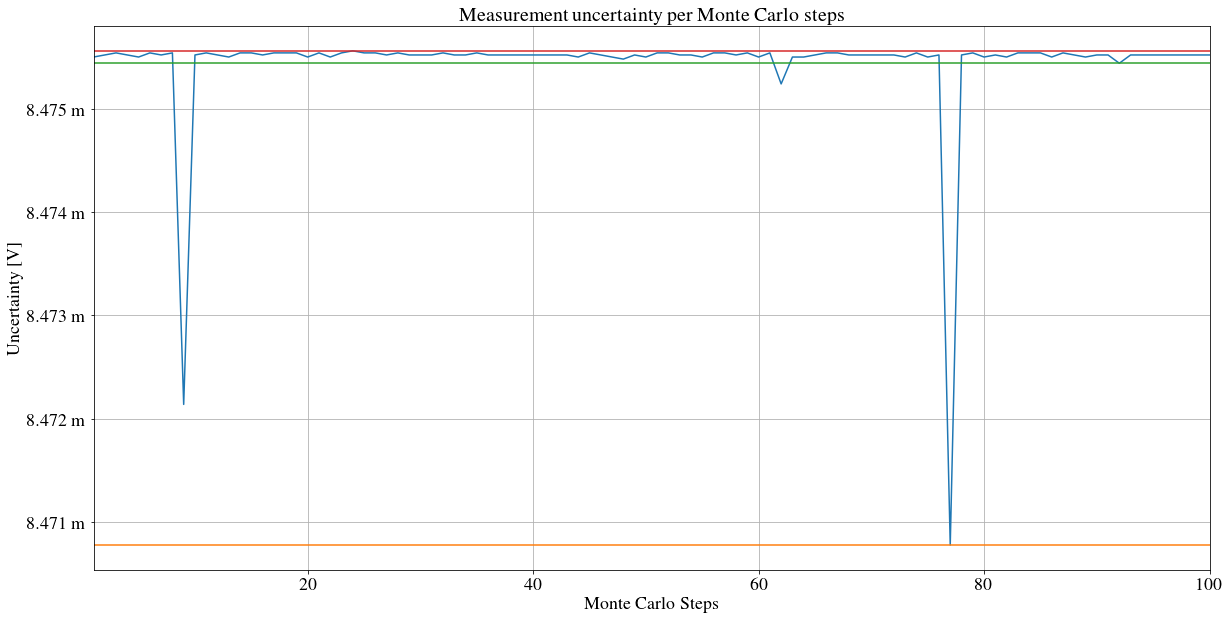

In [26]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(steps, integral)
ax.plot(steps, np.full((100),min_uncertainty))
ax.plot(steps, np.full((100),mean_uncertainty))
ax.plot(steps, np.full((100),max_uncertainty))
ax.set_ylabel('Uncertainty [V]')
formatter1 = EngFormatter(places=3)  # U+2009
ax.yaxis.set_major_formatter(formatter1)
ax.set_xlim(1,100)
ax.grid(True)
ax.set_xlabel('Monte Carlo Steps')
ax.set_title('Measurement uncertainty per Monte Carlo steps', fontsize=20)

# Conclusion

References:

[1] The Rogowski Coil Design Software, Radek Prochazka, Karel Draxler, Vladislav Kvasnicka

[2] High Accuracy AC Current Measurement Reference Design Using PCB Rogowski Coil Sensor

[3] AD8253 Programmable Gain Instrumentation Amplifie 

[4] Programmable Gain Instrumentation Amplifiers: Finding One that Works for You